In [43]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import emoji
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords

from pymorphy2 import MorphAnalyzer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, confusion_matrix,
    precision_recall_fscore_support, accuracy_score
)

from tensorflow.keras.preprocessing.text import Tokenizer                                                                                               # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences                                                                                           # type: ignore
from tensorflow.keras.models import Sequential                                                                                                          # type: ignore
from tensorflow.keras.layers import (                                                                                                                   # type: ignore
    Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D
)
from tensorflow.keras.callbacks import EarlyStopping                                                                                                                                # type: ignore

from catboost import CatBoostClassifier

import optuna


In [44]:
# Файлы : [категории]
files = {
    'avia': [r'avia\messages.html', r'avia\messages2.html', r'avia2\messages.html'],
    'rzd': [r'rzd\messages.html', r'rzd\messages2.html', r'rzd_gudok\messages2.html'],
    'piter': [r'piter\messages.html', r'piter_podoroznik\messages.html']
}

def read_files(file_paths):
    results = []
    for path in file_paths:
        with open(path, 'rb') as file:
            results.append(BeautifulSoup(file.read(), 'html.parser'))
    return results

avia_soups = read_files(files['avia'])
rzd_soups = read_files(files['rzd'])
piter_soups = read_files(files['piter'])

# * AVIA
s1 = BeautifulSoup("", 'html.parser') 
for soup in avia_soups:
    s1.append(soup)
# * railways
s2 = BeautifulSoup("", 'html.parser') 
for soup in rzd_soups:
    s2.append(soup)
# * SPB
s3 = BeautifulSoup("", 'html.parser')
for soup in piter_soups:
    s3.append(soup)


In [45]:
# Убираем эмодзи
def clean_emoji(t):
    return emoji.replace_emoji(t, replace='')

# Регулярные выражения
def clean(t):
    t = re.sub(r'[\xa0\u200e\u200b]', '', t) # Убираем пробелы и т.д
    t = re.sub(r'@\S+|#\w+', '', t) # Убираем хештеги и упоминания
    t = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', '', t) # Убираем email
    t = re.sub(r'\d+', '', t) # Убираем цифры
    t = re.sub(r'[^\w\s]','', t) # Убираем пунктуацию
    t = re.sub(r'http\S+|https\S+', '', t) # Убираем ссылки
    return t


In [4]:
# text1 = [item.get_text(" ", strip=True) for item in s1.find_all('div', class_='text')]
# text2 = [item.get_text(" ", strip=True) for item in s2.find_all('div', class_='text')]
# text3 = [item.get_text(" ", strip=True) for item in s3.find_all('div', class_='text')]

# df1 = pd.DataFrame({'text': text1, 'id': 0})# 0 - водный
# df2 = pd.DataFrame({'text': text2, 'id': 1})# 1 - жд
# df3 = pd.DataFrame({'text': text3, 'id': 2})# 2 - транспорт санкт-петербурга

# df = pd.concat([df1, df2, df3], ignore_index=True)


# # Применяем наши функции
# df['text'] = df['text'].str.lower()
# df['text'] = df['text'].apply(clean_emoji)
# df['text'] = df['text'].apply(clean)


In [46]:
# извлечения текста из всех div с классом text
def extract_texts_and_create_df(soup, category_id):
    texts = [item.get_text(" ", strip=True) for item in soup.find_all('div', class_='text')][:1000]
    return pd.DataFrame({'text': texts, 'id': category_id})

soup_dict = {
    'avia': s1,
    'rzd': s2,
    'piter': s3
}

# Создание DataFrame для каждой категории
df_list = [extract_texts_and_create_df(soup, category_id) for category_id, soup in enumerate(soup_dict.values())]

# Объединение всех DataFrame
df = pd.concat(df_list, ignore_index=True)

# Применение функций для обработки текста
def clean_text(text):
    text = text.lower()
    text = clean_emoji(text)
    return text

df['text'] = df['text'].apply(clean_text)

-----------------------

In [47]:
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

def remove_stopwords(text):
    word_list = text.split()
    clean_text = ' '.join([word for word in word_list if word not in stop_words])
    return clean_text

df['text'] = df['text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ivid0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df['id'].value_counts()

id
0    1000
1    1000
2     437
Name: count, dtype: int64

In [48]:
df = df.drop_duplicates()
df.isnull().sum()


text    0
id      0
dtype: int64

In [49]:
def lemmatize_text(text, morph):
    return ' '.join([morph.parse(word)[0].normal_form for word in text.split()])

# Лемматизация
morph = MorphAnalyzer()

df['text'] = df['text'].apply(lambda x: lemmatize_text(x, morph))
print(df['text'])

def tokenize_texts(texts):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    return sequences, tokenizer

X, tokenizer = tokenize_texts(df['text'])

maxlen = df['text'].apply(lambda x: len(x.split())).max()

# Дополнение последовательностей до максимальной длины
X = pad_sequences(X, maxlen=maxlen)
print(X)

0                                     гражданский авиация
1       бояться летать. конечный счете, именно способн...
2       странноватый чувство юмор пассажиров) #юмор #г...
3       #намписать «за 45 минута посадка к подойти стю...
4       оказалось, пожилой женщина «прилипла» унитазу....
                              ...                        
2432    первый ночь лето транспорт петербург перевезти...
2433    петербуржец показали, продвигаться строительст...
2434    петербург продолжаться работа водный дублёр би...
2435    улица петербург пополниться знак самокатчик вл...
2436    транспорт петербург работать ночь «алый паруса...
Name: text, Length: 2413, dtype: object
[[   0    0    0 ...    0  803  845]
 [   0    0    0 ...   50 4176 9668]
 [   0    0    0 ... 6603 9671 1493]
 ...
 [   0    0    0 ...  637  199  637]
 [   0    0    0 ...   89    1 9662]
 [   0    0    0 ... 1825 2677 5112]]


In [32]:
c = df['id'].to_list()
e = LabelEncoder()
e.fit(c)
y = e.transform(c)
y

array([0, 0, 0, ..., 2, 2, 2], dtype=int64)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # Определяем параметры для оптимизации с помощью Optuna
    embedding_dim = trial.suggest_categorical('embedding_dim', [64, 128, 256])
    lstm_units = trial.suggest_categorical('lstm_units', [32, 64, 128])
    dense_units = trial.suggest_categorical('dense_units', [32, 64, 128])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
    recurrent_dropout = trial.suggest_uniform('recurrent_dropout', 0.2, 0.5)

    model = Sequential([
        Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim),
        LSTM(lstm_units, recurrent_dropout=recurrent_dropout, return_sequences=True, dropout=dropout_rate),
        LSTM(lstm_units // 2, recurrent_dropout=recurrent_dropout, return_sequences=True, dropout=dropout_rate),
        GlobalMaxPooling1D(),
        Dense(dense_units, activation='relu', kernel_regularizer='l2'),
        Dropout(dropout_rate),
        Dense(units=len(np.unique(y)), activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.4, callbacks=[early_stopping])

    val_loss = np.min(history.history['val_loss'])
    return val_loss

# Создаем объект study и запускаем оптимизацию
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Выводим лучшие параметры и результаты
print('Количество завершенных проб:', len(study.trials))
print('Лучший результат:')
trial = study.best_trial
print('  Значение: {:.3f}'.format(trial.value))
print('  Параметры:')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


In [34]:
# optimal_params = study.best_params
optimal_params = {'embedding_dim': 256,
                'lstm_units': 32,
                'dense_units': 32,
                'dropout_rate': 0.24591831921884671,
                'recurrent_dropout': 0.25222606011768717,
                'learning_rate': 1.2027131141143945e-05}

In [35]:
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=optimal_params['embedding_dim']),
    LSTM(optimal_params['lstm_units']*2, recurrent_dropout=optimal_params['recurrent_dropout'], return_sequences=True, dropout=0.3),
    LSTM(optimal_params['lstm_units'], recurrent_dropout=optimal_params['recurrent_dropout'], return_sequences=True, dropout=0.3),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu', kernel_regularizer='l2'),
    Dropout(optimal_params['dropout_rate']),
    Dense(units=3, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.4, callbacks=[early_stopping])

Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - accuracy: 0.3958 - loss: 1.3729 - val_accuracy: 0.4275 - val_loss: 1.2889
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.5363 - loss: 1.2591 - val_accuracy: 0.7578 - val_loss: 1.0251
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.7845 - loss: 0.9758 - val_accuracy: 0.7850 - val_loss: 0.8070
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.7926 - loss: 0.8016 - val_accuracy: 0.7927 - val_loss: 0.6723
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.8019 - loss: 0.6764 - val_accuracy: 0.9236 - val_loss: 0.5302
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - accuracy: 0.9344 - loss: 0.5032 - val_accuracy: 0.9352 - val_loss: 0.4195
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - accuracy: 0.9682 - loss: 0.3553 - val_accuracy: 0.9249 - val_loss: 0.3936
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.9788 - loss: 0.2871 - val_accuracy: 0.

In [ ]:
y_pred_probabilities = model.predict(X_test)

# Получение индекса класса с наибольшей вероятностью для каждого объекта
y_pred = np.argmax(y_pred_probabilities, axis=-1)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(f'Precision на тестовом наборе: {precision}')
print(f'Recall на тестовом наборе: {recall}')
print(f'F1-score на тестовом наборе: {f1_score}')


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Precision на тестовом наборе: 0.8745025002421293
Recall на тестовом наборе: 0.8571428571428571
F1-score на тестовом наборе: 0.8634675180626711


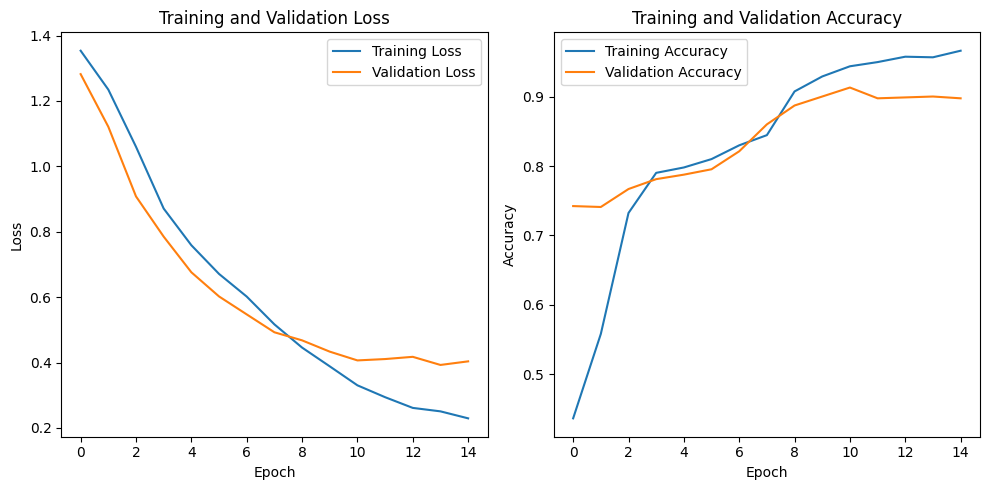

In [59]:
import matplotlib.pyplot as plt

# График кривых обучения
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


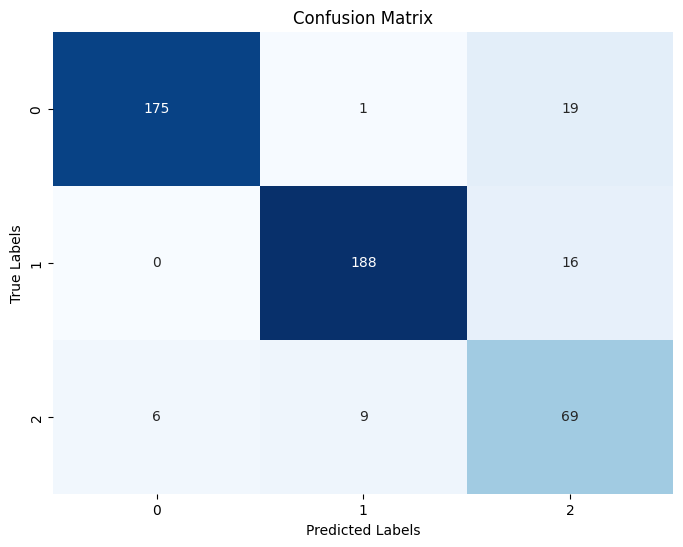

In [ ]:
# Получение вероятностей предсказания для каждого класса на тестовых данных
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=-1)  # Получение индекса класса с наибольшей вероятностью

# Создание матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [57]:

# Получение вероятностей предсказания для каждого класса на тестовых данных
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=-1)  # выбираем индекс класса с наибольшей вероятностью

# Оценка Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Macro F1-score
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f'Macro F1-score: {macro_f1:.2f}')

# Micro F1-score
micro_f1 = f1_score(y_test, y_pred, average='micro')
print(f'Micro F1-score: {micro_f1:.2f}')


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Accuracy: 86.96%
Macro F1-score: 0.83
Micro F1-score: 0.87


In [56]:
def classify_text(text, tokenizer, model):

    text_sequence = tokenizer.texts_to_sequences([text])
    text_padded = pad_sequences(text_sequence, maxlen=maxlen) 

    predictions = model.predict(text_padded)
    predicted_class_index = np.argmax(predictions)

    original_classes = {0: 'авиа', 1: 'железнодорожный', 2: 'транспорт Санкт-Петербурга'}
    predicted_class = original_classes[predicted_class_index]

    return predicted_class


text_to_classify = "В Майами двигатель самолета загорелся после взлета. На видео грузовой Boeing 747-8"
predicted_class = classify_text(text_to_classify, tokenizer, model)
print(f'Предсказанный класс для текста: {predicted_class}')

text_to_classify = "Сегодня пригородный поезд Челябинск - Курган отправился в первый рейс с обновлённым составом"
predicted_class = classify_text(text_to_classify, tokenizer, model)
print(f'Предсказанный класс для текста: {predicted_class}')

text_to_classify = "Вчера днем в Петербурге в совмещенном трамвайно-троллейбусном парк были пригнаны все действующие"
predicted_class = classify_text(text_to_classify, tokenizer, model)
print(f'Предсказанный класс для текста: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Предсказанный класс для текста: авиа
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Предсказанный класс для текста: железнодорожный
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Предсказанный класс для текста: транспорт Санкт-Петербурга
